# Super Resolution with a Pre-Trained GAN

Here I'll show how to use the fastai library to fine-tune a pre-trained GAN to be able to take poor quality images and reproduce them, but with drastically increased clarity, sharpness, and definition. GANs, or [generative adversarial networks](https://arxiv.org/abs/1406.2661) were invented by Ian Goodfellow in 2014.

GANs consist of a pair of neural networks: a generator network and a discriminator, or critic, network. The generator's job is to look at a set of data, say, a set of images, and learn how create convincing replications of those images.

The discriminator's job is to look at the same dataset of images, and then learn how to distinguish an original image from one of the generator's counterfeits.

The idea is that both networks create a sort of feedback effect, where the better the generator gets at producing convincing counterfeit images, the better the discriminator must be at telling the difference between an original and its replication. This then drives the generator to make even more convincing fakes.

In sum, the two competing networks push each other to get better and better at their respective jobs, and the end result of it all is that we will have a network (the generator) which is capable of creating extremely high quality images.

In this notebook we will see how a discriminator network will push our generator to learn to take a low-quality pet image (which we will have derived from the original high quality image in the pet imageset) and produce a sharp, high-quality version that's virtually indistinguishable from the genuine original high-res version.

We will see that using generator and discriminator networks with pre-trained weights drastically saves training time.

In [1]:
import fastai
from fastai import *
from fastai.vision import *
from fastai.callbacks import *
from fastai.vision.gan import *

In [2]:
# Get nicer looking graphs for retina displays
%config InlineBackend.figure_format = 'retina'

## Load the Dataset

As was the case for my [UNet for super resolution notebook](http://nbviewer.jupyter.org/github/jamesdellinger/fastai_deep_learning_course_part1_v3/blob/master/lesson7-superres-my-reimplementation.ipynb?flush_cache=true), I will also use the pets imageset for this super resolution task.

In [3]:
path = untar_data(URLs.PETS)
path_hr = path/'images'
path_lr = path/'crappy'

## Produce Low-Quality Images

We'll create a method below that will take the original high-quality images from the pets imageset and create set of low-quality (96 px) counterparts.

In [4]:
from PIL import Image, ImageDraw, ImageFont

In [6]:
def crappify(fn,i):
    dest = path_lr/fn.relative_to(path_hr)
    dest.parent.mkdir(parents=True, exist_ok=True)
    img = PIL.Image.open(fn)
    targ_sz = resize_to(img, 96, use_min=True)
    img = img.resize(targ_sz, resample=PIL.Image.BILINEAR).convert('RGB')
    w,h = img.size
    q = random.randint(10,70)
    # Add some white numbers to the low-quality images.
    # Our network will learn how to make them disappear.
    ImageDraw.Draw(img).text((random.randint(0,w//2),random.randint(0,h//2)), str(q), fill=(255,255,255))
    img.save(dest, quality=q)

Run the cell below to create the low-quality images.

In [7]:
# Uncomment the following two lines if running this NB for the first time.
# il = ImageItemList.from_folder(path_hr)
# parallel(crappify, il.items)

## Pre-train the Generator

First let's specify the batch size and training image size.

In [5]:
bs = 32
size = 128

We'll first train our generator to take the low-quality (96 px) images and improve them so that they appear as if they were 128 px. To accomplish this, we downsize the original high-res images in pets imageset to size 128, and use these as our training targets.

Our pretrained weights come from a ResNet34 network trained on ImageNet.

In [21]:
arch = models.resnet34
src = ImageImageList.from_folder(path_lr).random_split_by_pct(0.1, seed=42)

In [22]:
def get_data(bs,size):
    data = (src.label_from_func(lambda x: path_hr/x.name)
           .transform(get_transforms(max_zoom=2.), size=size, tfm_y=True)
           .databunch(bs=bs).normalize(imagenet_stats, do_y=True))
    
    data.c=3
    return data

In [23]:
data_gen = get_data(bs,size)

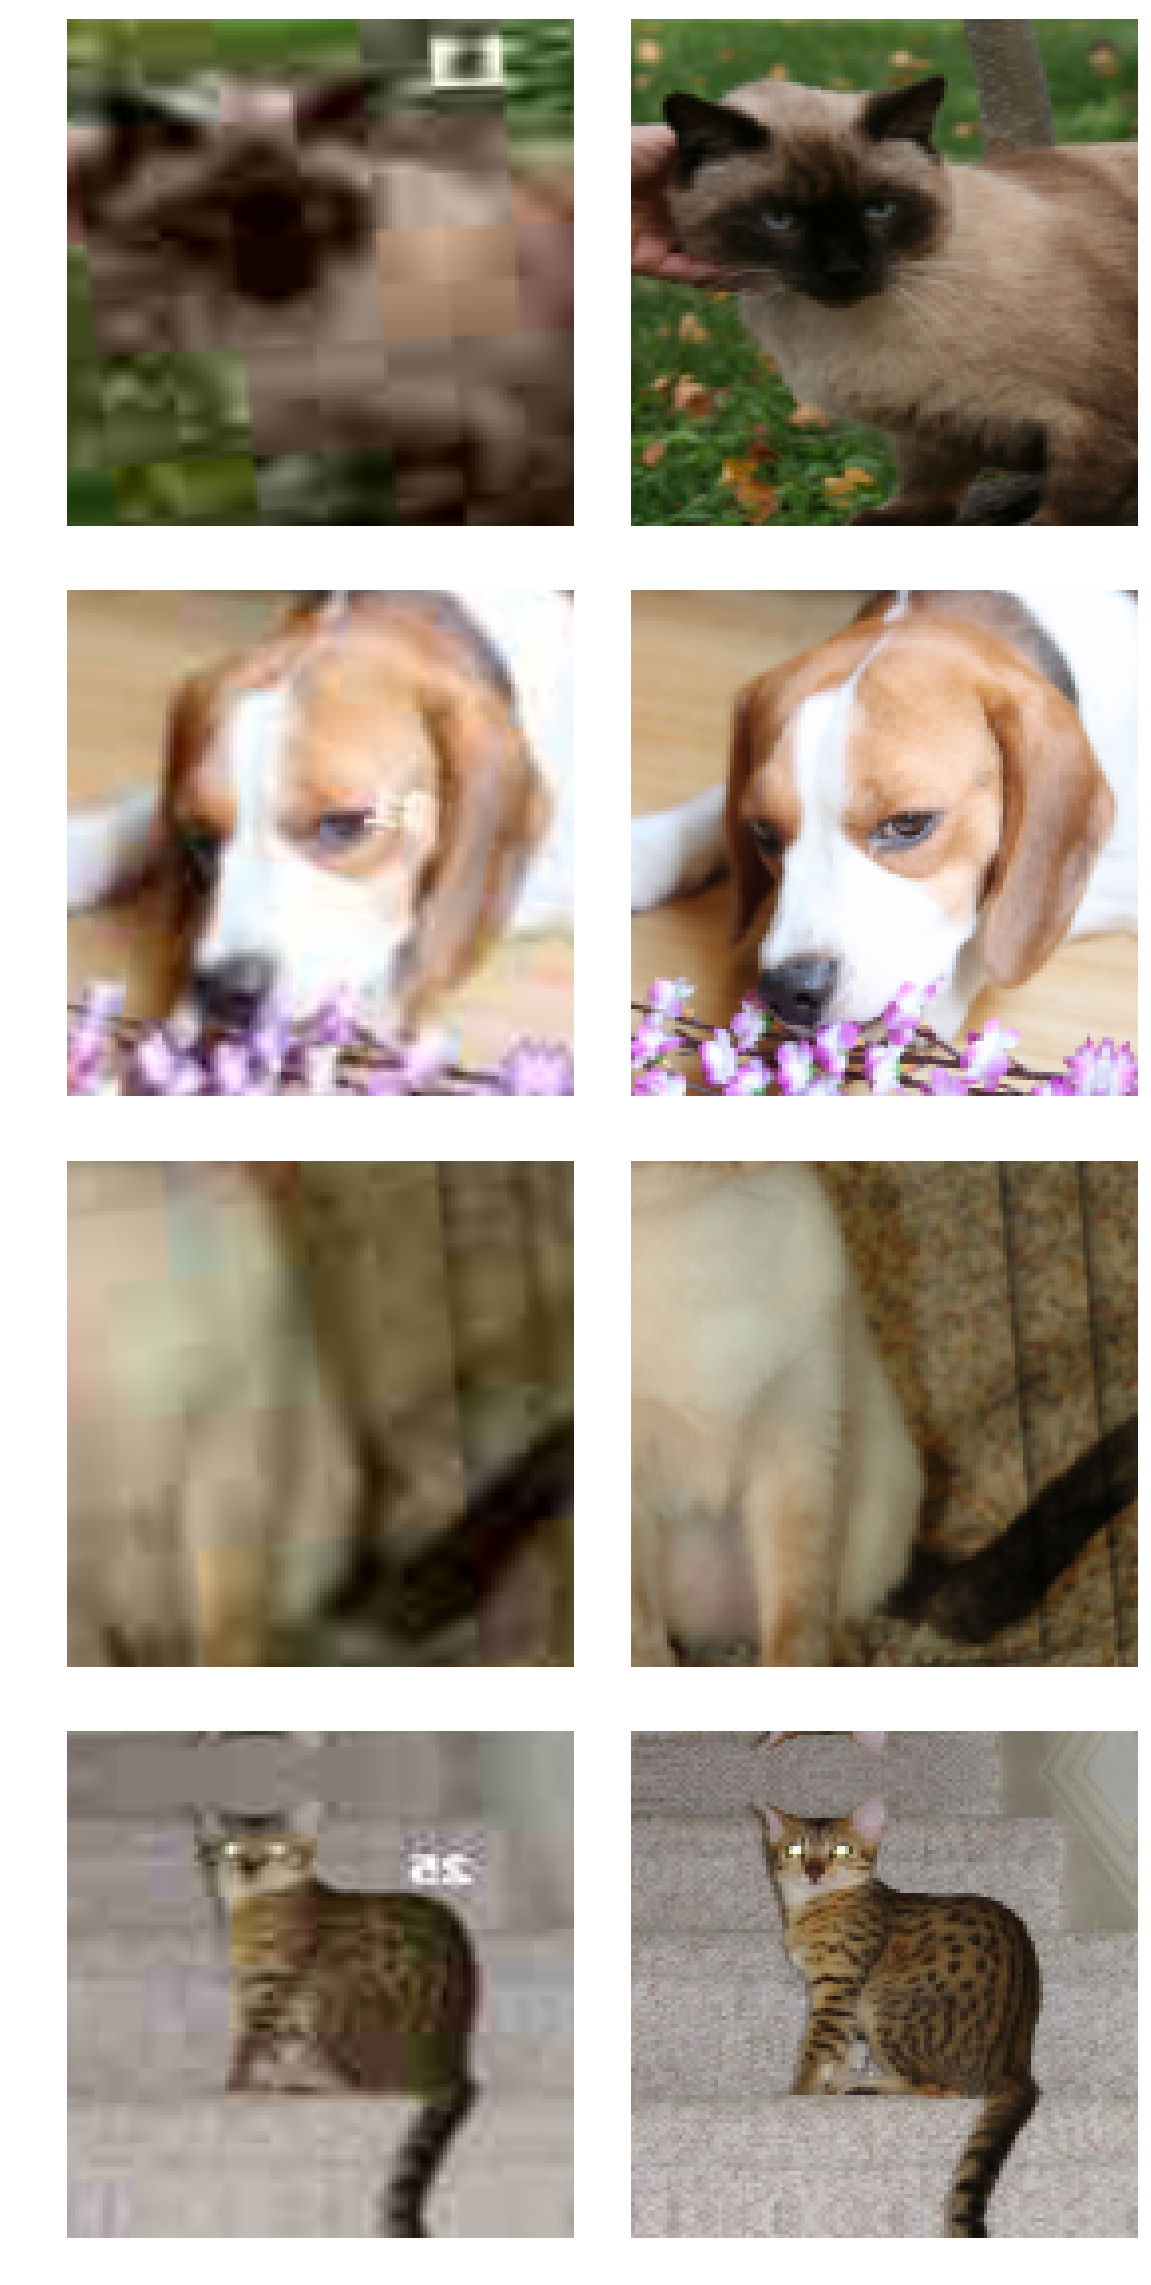

In [12]:
data_gen.show_batch(4)

The low-quality images are in the left column. Notice that some of them now have random white numbers appearing in the image. Our generator will learn how to produce images without numbers, that appear as close as possible to the 128 px targets in the right column.

In [6]:
wd = 1e-3

In [7]:
y_range = (-3., 3.)

In [8]:
loss_gen = MSELossFlat()

In [9]:
def create_gen_learner():
    return unet_learner(data_gen, arch, wd=wd, blur=True, norm_type=NormType.Weight,
                        self_attention=True, y_range=y_range, loss_func=loss_gen)

In [17]:
learn_gen = create_gen_learner()

In [18]:
learn_gen.fit_one_cycle(2, pct_start=0.8)

epoch,train_loss,valid_loss
1,0.061509,0.053935
2,0.052759,0.048654


In [19]:
learn_gen.unfreeze()

In [20]:
learn_gen.fit_one_cycle(3, slice(1e-6,1e-3))

epoch,train_loss,valid_loss
1,0.049536,0.047604
2,0.048142,0.045312
3,0.046086,0.044446


In [21]:
learn_gen.save('gen-pre1')

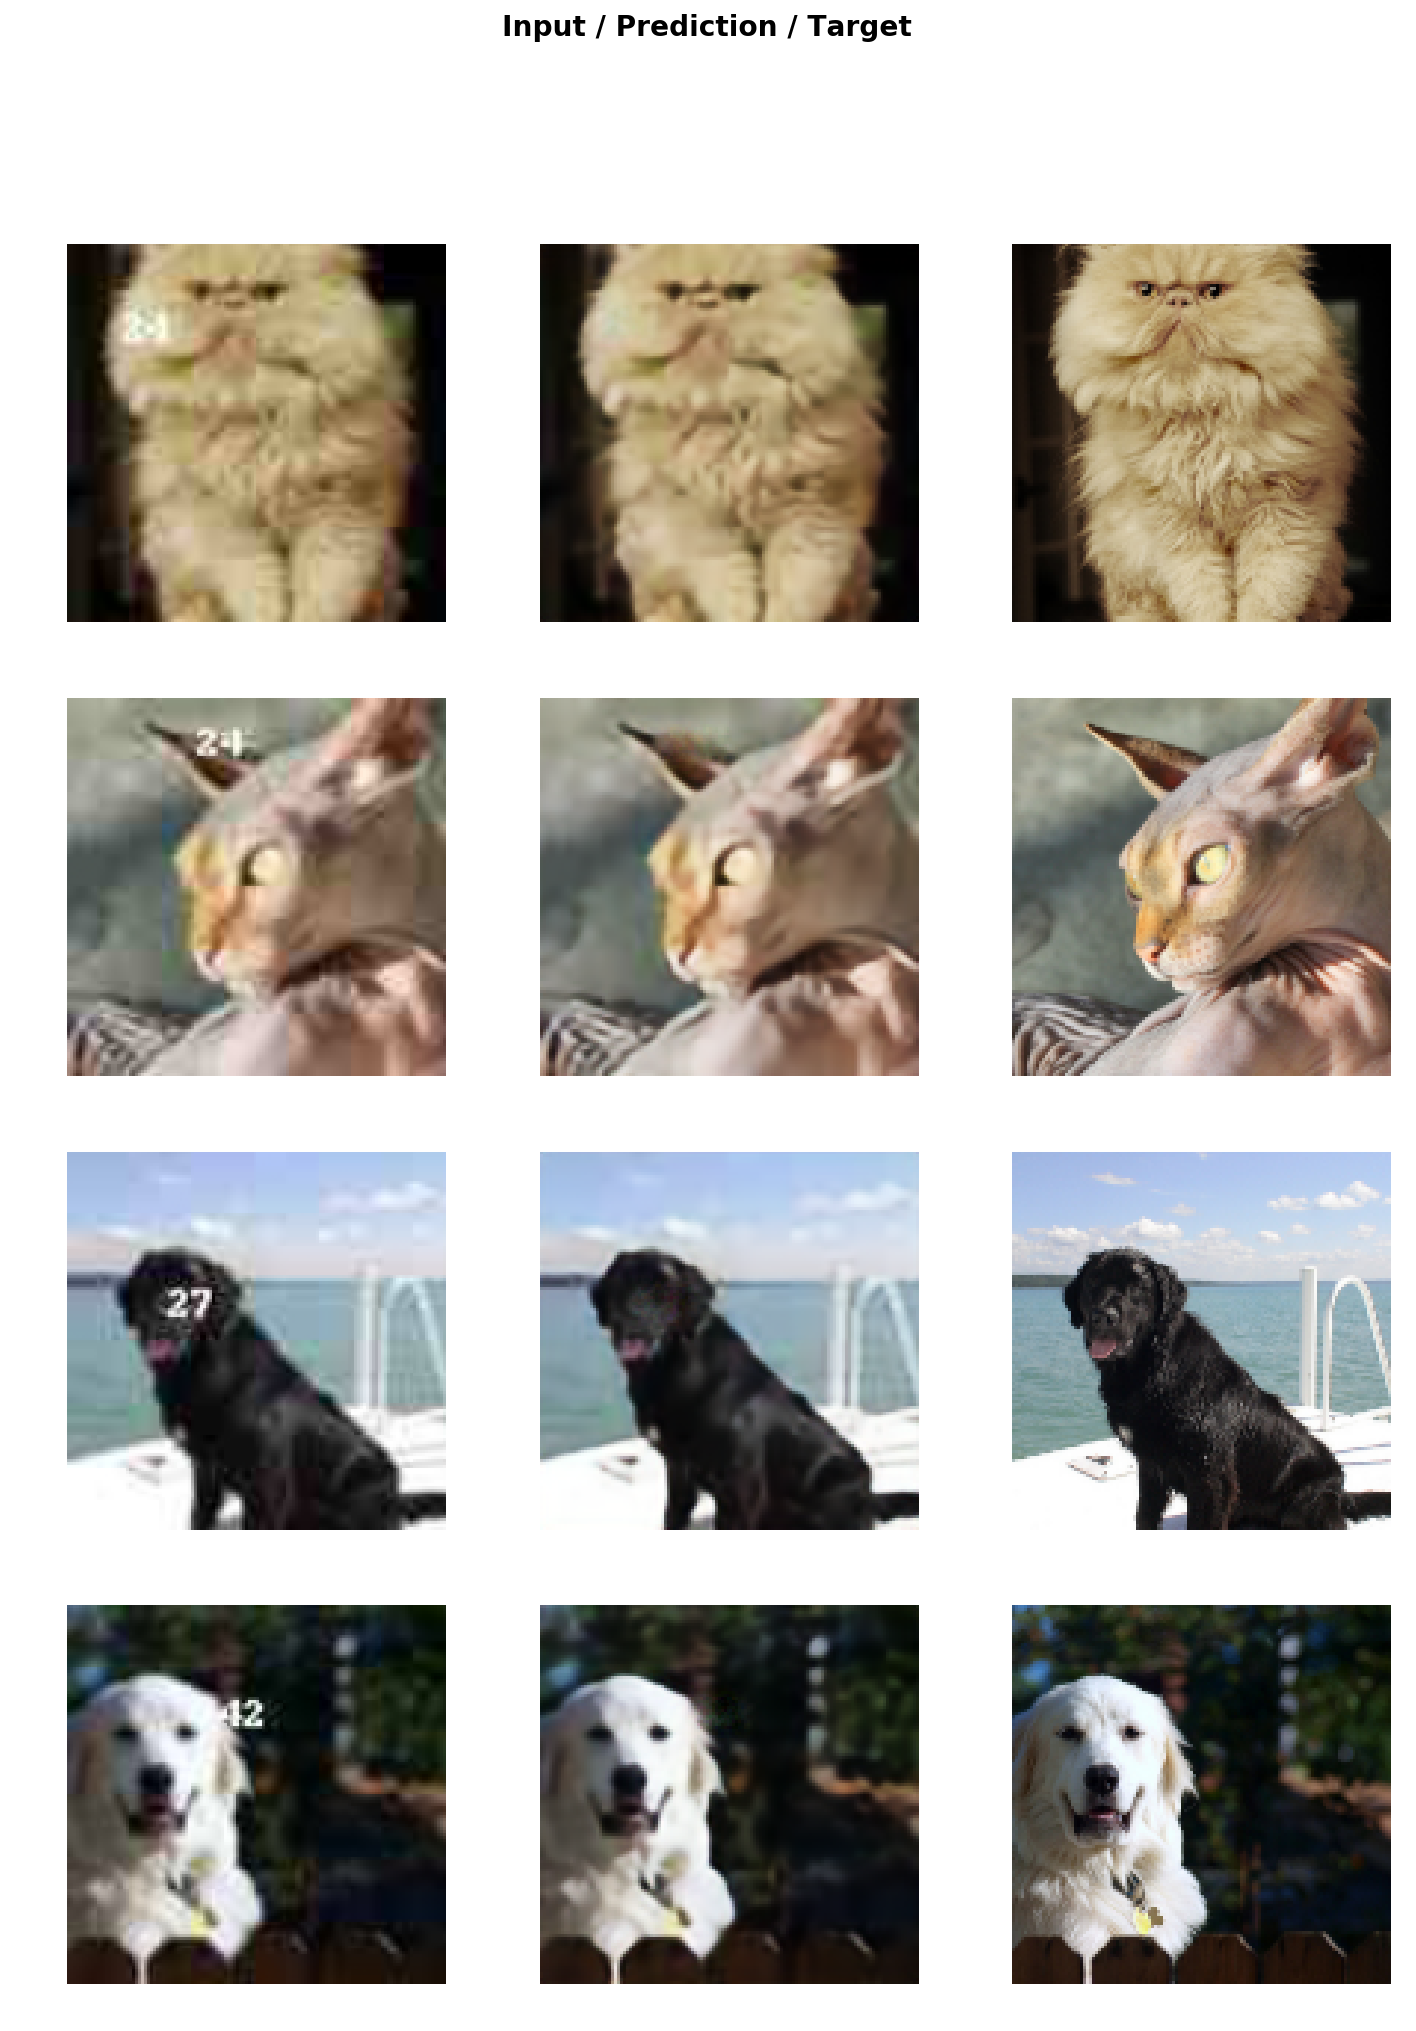

In [22]:
learn_gen.show_results(rows=4)

We can see that after pre-training, our generator has learned how to remove text overlays from images.

## Save generated images

We need to now use our pre-trained generator to create images that improve upon each of the low-quality images. We'll store these predictions and then we can pre-train the discriminator to properly classify the generated images as fakes, and the original target images as genuine.

In [24]:
learn_gen.load('gen-pre1');

In [10]:
name_gen = 'image_gen'
path_gen = path/name_gen

In [27]:
path_gen.mkdir(exist_ok=True)

In [28]:
def save_preds(dl):
    i=0
    names = dl.dataset.items
    
    for b in dl:
        preds = learn_gen.pred_batch(batch=b, reconstruct=True)
        for o in preds:
            o.save(path_gen/names[i].name)
            i += 1

In [29]:
save_preds(data_gen.fix_dl)

A quick sanity check to make sure that our generator's predictions (generated images) are saved to the right directory and appear about how we'd expect:

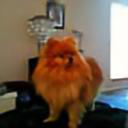

In [30]:
PIL.Image.open(path_gen.ls()[0])

## Pre-Train the Discriminator

We can think of the predictions we just had our generator produce as its *first attempt* at creating improved versions of low-quality images. 

There's still a lot of room for improvement -- it hasn't yet been challenged by a discriminator network that can tell the difference between the original target images and the generator's creations, but that's okay for the time being. 

Indeed, now that we have this *generated* set of 128 px pet images, we can feed these along with the corresponding set of original 128px targets (the genuine images) into our discriminator network, and also pre-train it to distinguish the counterfeits from the genuine images.

In [31]:
# A cool trick to clear out GPU memory without restarting the Jupyter kernel.
learn_gen=None
gc.collect()

7

In [11]:
def get_crit_data(classes, bs, size):
    src = ImageItemList.from_folder(path, include=classes).random_split_by_pct(0.1, seed=42)
    ll = src.label_from_folder(classes=classes)
    data = (ll.transform(get_transforms(max_zoom=2.), size=size)
            .databunch(bs=bs).normalize(imagenet_stats))
    
    data.c = 3
    return data

In [15]:
data_crit = get_crit_data([name_gen, 'images'], bs=bs, size=size)

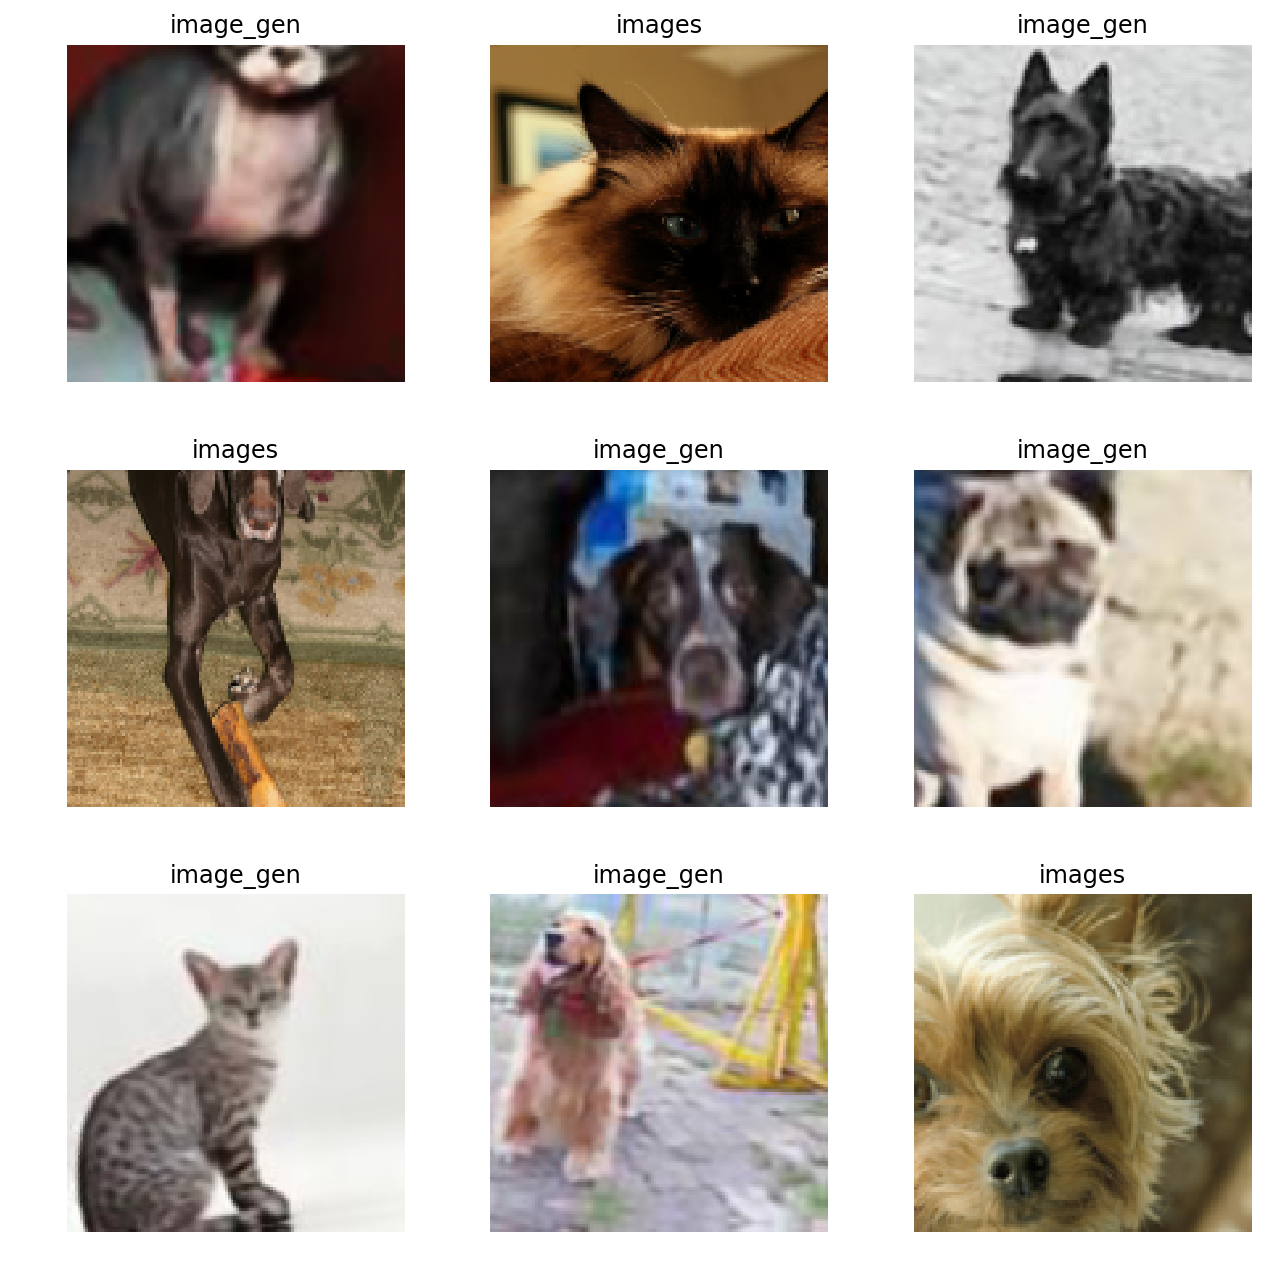

In [34]:
data_crit.show_batch(rows=3, ds_type=DatasetType.Train, imgsize=3)

The sampling above shows the both the genuine images, labeled `images`, as well as the generator's predictions, labeled `image_gen`, that the discriminator will be pre-trained to distinguish between.

In [12]:
loss_critic = AdaptiveLoss(nn.BCEWithLogitsLoss())

In [13]:
def create_critic_learner(data, metrics):
    return Learner(data, gan_critic(), metrics=metrics, loss_func=loss_critic, wd=wd)

In [37]:
learn_critic = create_critic_learner(data_crit, accuracy_thresh_expand)

In [39]:
learn_critic.fit_one_cycle(6, 1e-3)

epoch,train_loss,valid_loss,accuracy_thresh_expand
1,0.602407,0.582229,0.700655
2,0.277057,0.159984,0.947350
3,0.127428,0.152967,0.944473
4,0.098541,0.270246,0.889858
5,0.059270,0.061445,0.982137
6,0.048454,0.070686,0.980940


In [40]:
learn_critic.save('critic-pre1')

## GAN: Putting it all together

The final step is to combine our pre-trained generator network and our pre-trained discriminator network together to create a GAN.

In [41]:
# Clear out GPU memory
learn_crit=None
learn_gen=None
gc.collect()

15863

To create a GAN learner in fastai, we need only specify the discriminator and generator networks, and then create a switcher callback, whose job is to decide when to train the discriminator and when to train the generator.

Our game plan here is to train the discriminator for as many iterations as necessary until its loss dips below `0.5`, at which point we will then train the generator for one iteration. This cycle will repeat until the cycle length (we will do 40 epochs for our first cycle) is exhausted.

The discriminator's loss is simply the average of `learn_crit.loss_func` (`nn.BCEWithLogitsLoss()`) on both the batch real predictions and the batch of fake predictions.

The generator's loss is the weighted sum (the weights in `weights_gen`) of `learn_crit.loss_func` on the batch of fake images created by the generator, and `learn_gen.loss_func` (`MSELossFlat()`) which is measured by the difference between the generated counterfeit images and their genuine target counterparts.

In other words, we measure the discriminator's loss based on how well it can tell a fake from a genuine image. And we measure the discriminator's loss based on how often it can fool the discriminator, as well as how close its generated images actually resemble their genuine counterparts.

#### 1. Get the Discriminator's Data Bunch

We're gonna need to downsize the batchsize from 32 to 8 in order to fit this on the GPU.

In [24]:
bs = 8

In [25]:
data_crit = get_crit_data(['crappy', 'images'], bs=bs, size=size)

#### 2. Get the Discriminator Network

In [26]:
learn_crit = create_critic_learner(data_crit, metrics=None).load('critic-pre1')

#### 3. Get the Generator Network

In [27]:
learn_gen = create_gen_learner().load('gen-pre1')

#### 4. Create the Switcher Callback

In [28]:
switcher = partial(AdaptiveGANSwitcher, critic_thresh=0.65)

#### 5. Create the GAN Network and add Callback for Discriminative Learning Rates

Adding this callback allows us to train the discriminator using a different learning rate than we use to train the generator.

In [29]:
learn = GANLearner.from_learners(learn_gen, learn_crit, weights_gen=(1.,50.), show_img=False, switcher=switcher,
                                 opt_func=partial(optim.Adam, betas=(0.,0.99)), wd=wd)
learn.callback_fns.append(partial(GANDiscriminativeLR, mult_lr=5.))

In [30]:
lr = 1e-4

Note that when we train a GAN, we can't observe progress by looking at the training loss. Since this loss is comprised of the loss functions of two separate networks that are competing against each other, we expect that ideally it will remain constant, since one network improving (lowering its loss) naturally means that its counterpart will see an increase in its own loss.

Instead, when conducting extended training, practitioners typically print out images produced by the generator every several epochs. Observing the quality of these images gives a much better indication of whether the GAN is anywhere near close to being able to achieve its objective (produce sharp images in our case).

For this notebook, in order to save space, I won't print out images during training.

In [31]:
learn.fit(40,lr)

epoch,train_loss,gen_loss,disc_loss
1,1.909902,1.936750,3.669923
2,1.983094,1.953079,3.581594
3,2.035652,1.855548,3.605556
4,1.996986,2.024948,3.561522
5,1.941241,1.912726,3.529305
6,2.003138,0.884369,3.567219
7,2.013894,1.899223,3.630047
8,1.979904,1.914898,3.553614
9,2.007653,1.854903,3.643748
10,1.941521,2.022038,3.606867


In [32]:
learn.save('gan-1')

We'll do one more training cycle in order to fine-tune our generator. Increasing the target image size from 128 to 192 should help our model to learn to add greater detail and clarity to fuzzy images. 

In [33]:
bs = 4
size = 192

In [34]:
learn.data = get_data(bs, size)

In [35]:
learn.fit(10, lr/2)

epoch,train_loss,gen_loss,disc_loss
1,2.447732,2.439027,4.797899
2,2.388296,2.373074,4.708158
3,2.332597,2.442664,4.511331
4,2.531640,2.516122,4.867640
5,2.423813,2.476433,4.776405
6,2.431587,2.482094,4.701179
7,2.437263,2.309251,4.765074
8,2.453543,2.405588,4.659098
9,2.356060,2.442733,4.720308
10,2.364441,1.699730,4.715442


In [36]:
learn.save('gan-2')

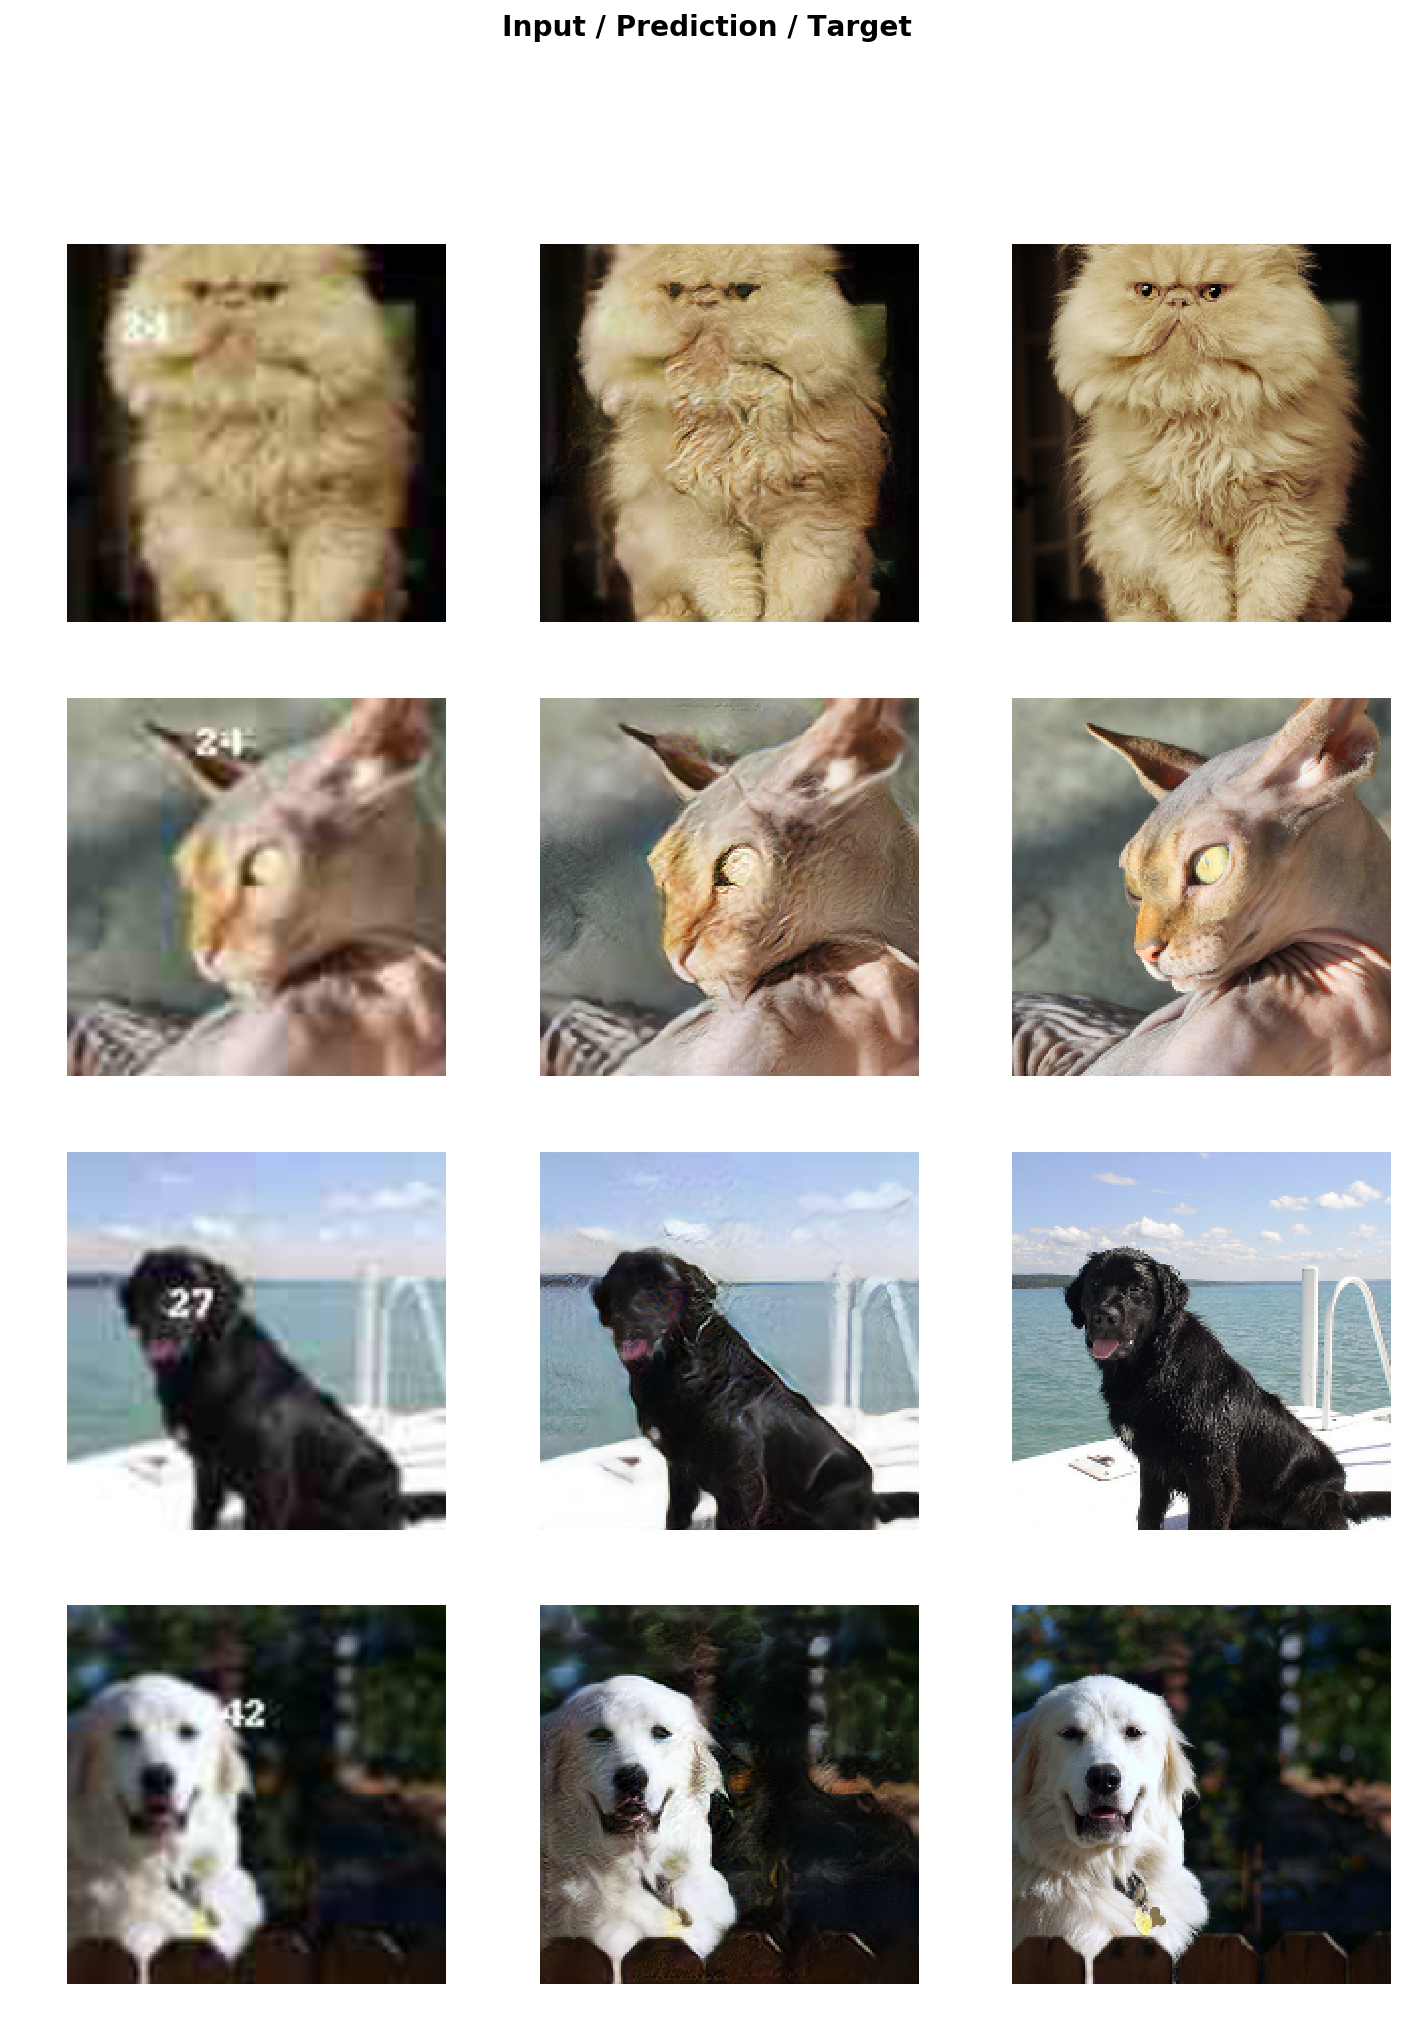

In [38]:
learn.show_results(rows=4)

After 50 epochs of training, we've got a GAN that does a fairly nice job of cleaning up fuzzy images. Though as can be seen from the samples above, its performance is not consistently exceptional. Sometimes image backgrounds contain some strange artifacts, and with some images the GAN struggles to properly paint in the details of the pets' faces.

My [UNet model + perceptual loss function](http://nbviewer.jupyter.org/github/jamesdellinger/fastai_deep_learning_course_part1_v3/blob/master/lesson7-superres-my-reimplementation.ipynb?flush_cache=true) delivered far superior results at this particular super resolution task, and it trained in just over half the time it took to train this GAN.